In [1]:
import sys
sys.path.append('/home/esp/data_analyze/05.02.2025/code')

import pandas as pd
import microbiome_analysis as ma
import microbiome_subgroup_analysis as msa

import warnings
warnings.filterwarnings('ignore')

# Настройка путей и переменных
MAIN_DIR = '05.02.2025'
PART_OF_PATH = 'genus_subgroup'
GROUP_LIST = ['OB-BPD/DS ', 'CHJ-BPD/DS+', 'CHJ-BPD/DS-', 'CN/SD ']
SUPGROUP_LIST = ['MAM-J', 'MAM-I', 'MAMLI', 'MAM-D', 'Fecal']

DF = pd.read_csv(
    f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/out_data/{PART_OF_PATH}_out.csv',
    sep='\t',
    index_col=[0]
)

PATH_TO_ALPHA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/data'
PATH_TO_ALPHA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/figure'
PATH_TO_BETA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/data'
PATH_TO_BETA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/figure'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/data'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/figure'
PATH_TO_VENN_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/venn/figure'
PATH_TO_FB_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/data'
PATH_TO_FB_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/figure'

SAFE_DATA = True
SHOW = True

#groups = DF['GROUP'].unique()
PALETTE = {GROUP_LIST[0]: '#1924B1', GROUP_LIST[1]: '#74E600', GROUP_LIST[2]:'#7200e6', GROUP_LIST[3]:'#b1a619'}
ma.PALETTE = PALETTE
ma.GROUP_LIST = GROUP_LIST

ma.PATH_TO_ALPHA_OUTPUT_DATA = PATH_TO_ALPHA_OUTPUT_DATA
ma.PATH_TO_ALPHA_OUTPUT_FIGURE = PATH_TO_ALPHA_OUTPUT_FIGURE
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA  = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE
ma.PATH_TO_VENN_OUTPUT_FIGURE = PATH_TO_VENN_OUTPUT_FIGURE
ma.PATH_TO_BETA_OUTPUT_DATA = PATH_TO_BETA_OUTPUT_DATA
ma.PATH_TO_BETA_OUTPUT_FIGURE = PATH_TO_BETA_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_FIGURE = PATH_TO_FB_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_DATA = PATH_TO_FB_OUTPUT_DATA
ma.SHOW = SHOW
ma.SAFE_DATA = SAFE_DATA


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import itertools

def filter_taxa_by_prevalence(df, 
                              abundance_col='RelativeAbundance', 
                              sample_col='#SampleID', 
                              taxonomy_col='Taxonomy',
                              presence_threshold=0.01, 
                              min_samples_fraction=0.1):
    n_samples = df[sample_col].nunique()
    presence_counts = (
        df[df[abundance_col] >= presence_threshold]
        .groupby(taxonomy_col)[sample_col]
        .nunique()
    )
    min_count = int(np.ceil(n_samples * min_samples_fraction))
    prevalent_taxa = presence_counts[presence_counts >= min_count].index
    filtered_df = df[df[taxonomy_col].isin(prevalent_taxa)].copy()
    return filtered_df

def remove_outliers_iqr(df, group_col, value_col, factor=1.5):
    filtered_list = []
    outliers_list = []
    
    for g, sub_df in df.groupby(group_col):
        Q1 = sub_df[value_col].quantile(0.25)
        Q3 = sub_df[value_col].quantile(0.75)
        iqr = Q3 - Q1
        lower = Q1 - factor * iqr
        upper = Q3 + factor * iqr
        
        mask = sub_df[value_col].between(lower, upper)
        filtered_list.append(sub_df[mask])
        outliers_list.append(sub_df[~mask])
    
    return pd.concat(filtered_list), pd.concat(outliers_list)

def test_taxa_kruskal_fdr(df, group_col='GROUP', value_col='RelativeAbundance', taxonomy_col='Taxonomy'):
    results = []
    unique_taxa = df[taxonomy_col].unique()

    for taxon in unique_taxa:
        df_taxon = df[df[taxonomy_col] == taxon]
        grouped_data = [
            df_taxon.loc[df_taxon[group_col] == g, value_col].dropna().values
            for g in df[group_col].unique()
        ]
        if all(len(arr) > 0 for arr in grouped_data):
            stat, p_val = kruskal(*grouped_data)
            results.append((taxon, p_val))

    if len(results) > 0:
        taxa, pvals = zip(*results)
        pvals_corrected = multipletests(pvals, alpha=0.05, method='fdr_bh')[1]
        results_df = pd.DataFrame({
            taxonomy_col: taxa,
            'p_value_raw': pvals,
            'p_value_fdr': pvals_corrected
        })
        return results_df.sort_values('p_value_fdr')
    else:
        return pd.DataFrame(columns=[taxonomy_col, 'p_value_raw', 'p_value_fdr'])



df_filtered = filter_taxa_by_prevalence(DF, 
                                        presence_threshold=0.01, 
                                        min_samples_fraction=0.1)


results_kruskal = test_taxa_kruskal_fdr(df_filtered, 'GROUP', 'RelativeAbundance', 'Taxonomy')
print(df_filtered.shape)

(5719, 7)


In [3]:
df = df_filtered.copy()

# Упрощаем названия таксонов: берём только последний уровень
df['Taxonomy'] = df['Taxonomy'].apply(
    lambda x: x.split('|')[-1] if isinstance(x, str) else x
)


=== Analyzing Subgroup: MAM-J ===

=== SHANNON ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)   0.554575   3.0  0.285235  0.835576
Residual  16.202298  25.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.1889  0.9636 -0.9023  1.2802   False
1  CHJ-BPD/DS+       CN/SD    -0.1425  0.9838 -1.2338  0.9487   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1873  0.9737 -1.4001  1.0256   False
3  CHJ-BPD/DS-       CN/SD    -0.3315  0.8670 -1.5151  0.8522   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.3762  0.8546 -1.6728  0.9204   False


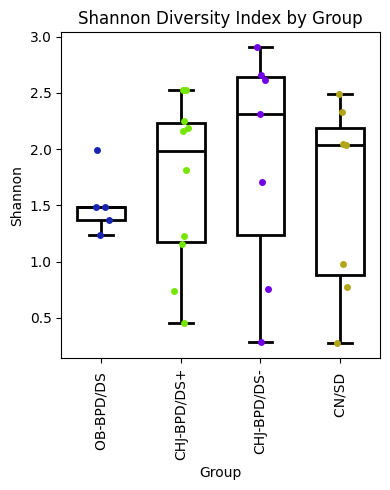


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.043580   3.0  0.190818  0.901651
Residual  1.903213  25.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0547  0.9775 -0.3193  0.4287   False
1  CHJ-BPD/DS+       CN/SD    -0.0521  0.9804 -0.4261  0.3219   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0305  0.9970 -0.3852  0.4462   False
3  CHJ-BPD/DS-       CN/SD    -0.1068  0.8866 -0.5124  0.2989   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0241  0.9988 -0.4685  0.4203   False


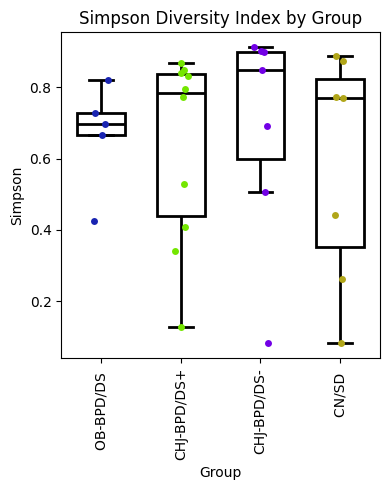


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)  243.123645   3.0  3.996003  0.018743
Residual  507.014286  25.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj    lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -1.9286  0.8207  -8.0331  4.1759   False
1  CHJ-BPD/DS+       CN/SD     0.5000  0.9959  -5.6045  6.6045   False
2  CHJ-BPD/DS+   OB-BPD/DS    -7.7000  0.0219 -14.4848 -0.9152    True
3  CHJ-BPD/DS-       CN/SD     2.4286  0.7457  -4.1927  9.0498   False
4  CHJ-BPD/DS-   OB-BPD/DS    -5.7714  0.1540 -13.0247  1.4818   False


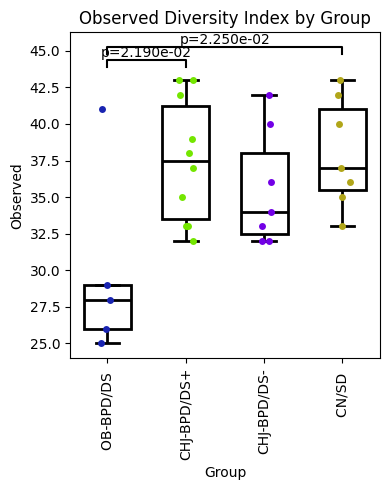


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.035022   3.0  0.237185  0.869579
Residual  1.230477  25.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0566  0.9540 -0.2441  0.3574   False
1  CHJ-BPD/DS+       CN/SD    -0.0392  0.9838 -0.3399  0.2615   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0192  0.9986 -0.3534  0.3151   False
3  CHJ-BPD/DS-       CN/SD    -0.0958  0.8500 -0.4220  0.2304   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0758  0.9361 -0.4331  0.2815   False


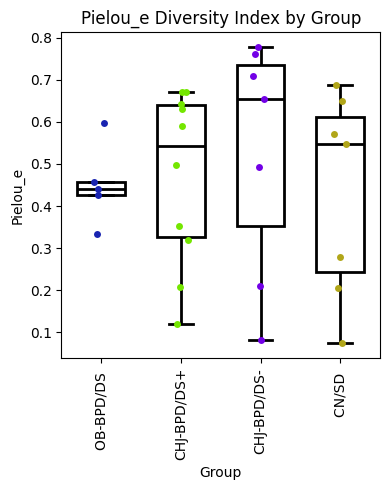

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:475: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


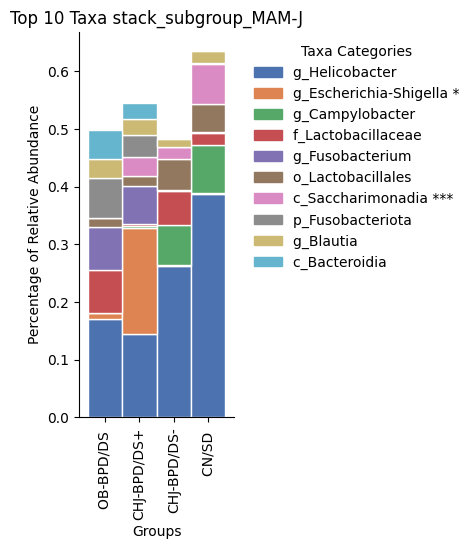

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:586: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


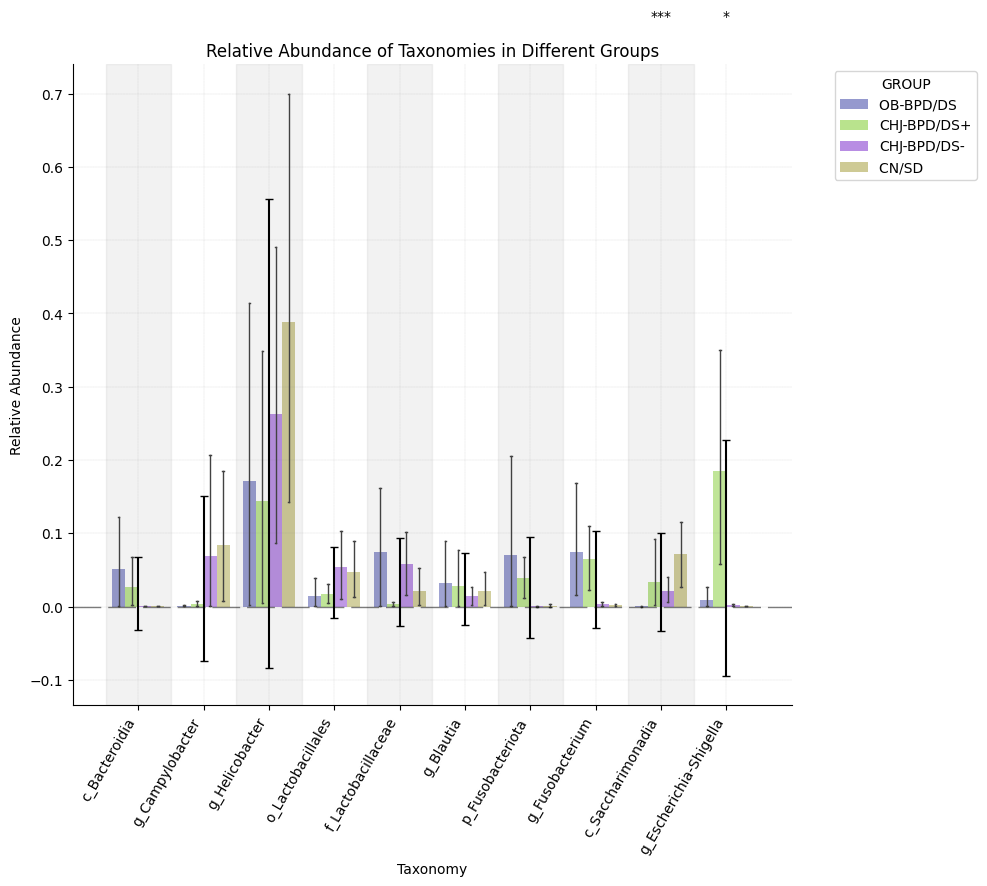


=== Analyzing Subgroup: MAM-I ===

=== SHANNON ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)   1.470061   3.0  1.013953  0.404566
Residual  11.115373  23.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.5940  0.3488 -1.5634  0.3755   False
1  CHJ-BPD/DS+       CN/SD    -0.3747  0.7380 -1.3886  0.6392   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2154  0.9441 -1.2884  0.8577   False
3  CHJ-BPD/DS-       CN/SD     0.2192  0.9409 -0.8510  1.2895   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.3786  0.7892 -0.7479  1.5050   False


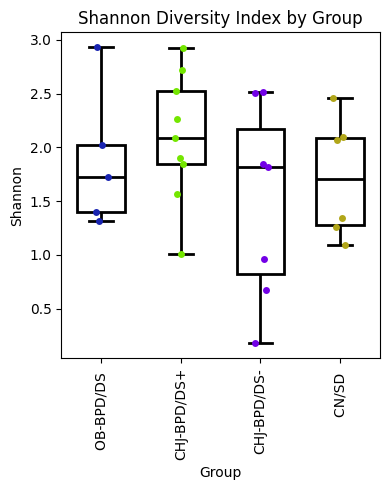


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.158911   3.0  1.219789  0.325005
Residual  0.998795  23.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1803  0.3383 -0.4709  0.1103   False
1  CHJ-BPD/DS+       CN/SD    -0.0942  0.8263 -0.3981  0.2097   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0027  1.0000 -0.3190  0.3243   False
3  CHJ-BPD/DS-       CN/SD     0.0861  0.8789 -0.2347  0.4069   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1829  0.4542 -0.1547  0.5206   False


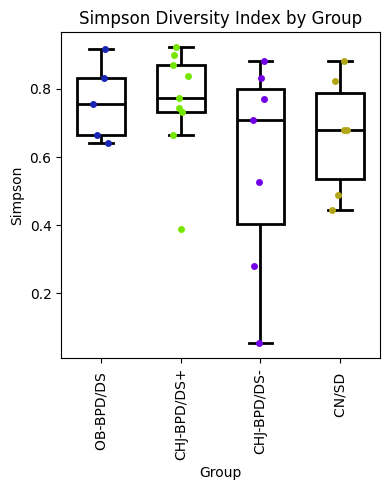


=== OBSERVED ANOVA ===
               sum_sq    df        F    PR(>F)
C(GROUP)  262.112169   3.0  5.40897  0.005773
Residual  371.517460  23.0      NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj    lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -2.6032  0.5811  -8.2081  3.0018   False
1  CHJ-BPD/DS+       CN/SD     0.1111  0.9999  -5.7507  5.9729   False
2  CHJ-BPD/DS+   OB-BPD/DS    -8.2889  0.0061 -14.4924 -2.0853    True
3  CHJ-BPD/DS-       CN/SD     2.7143  0.6246  -3.4734  8.9020   False
4  CHJ-BPD/DS-   OB-BPD/DS    -5.6857  0.1020 -12.1981  0.8267   False


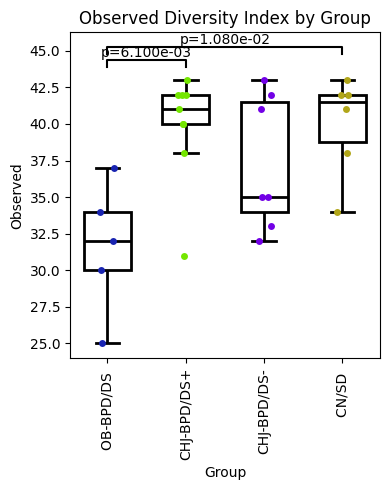


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.106256   3.0  1.022736  0.400818
Residual  0.796520  23.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1531  0.3810 -0.4126  0.1064   False
1  CHJ-BPD/DS+       CN/SD    -0.0969  0.7574 -0.3684  0.1745   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0255  0.9946 -0.3127  0.2617   False
3  CHJ-BPD/DS-       CN/SD     0.0562  0.9476 -0.2303  0.3427   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1276  0.6505 -0.1739  0.4291   False


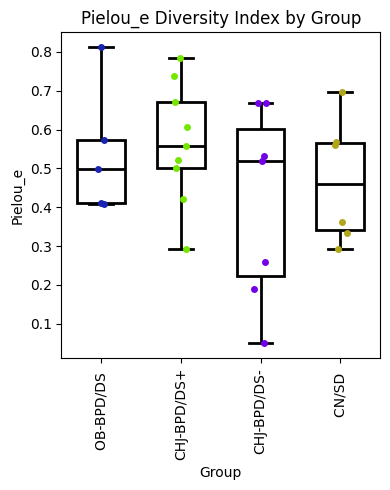

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:475: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


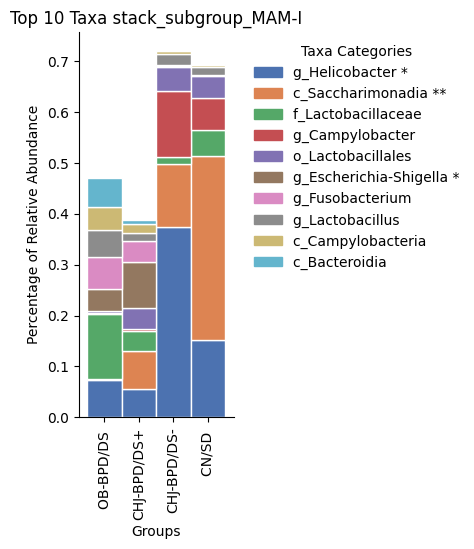

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:586: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


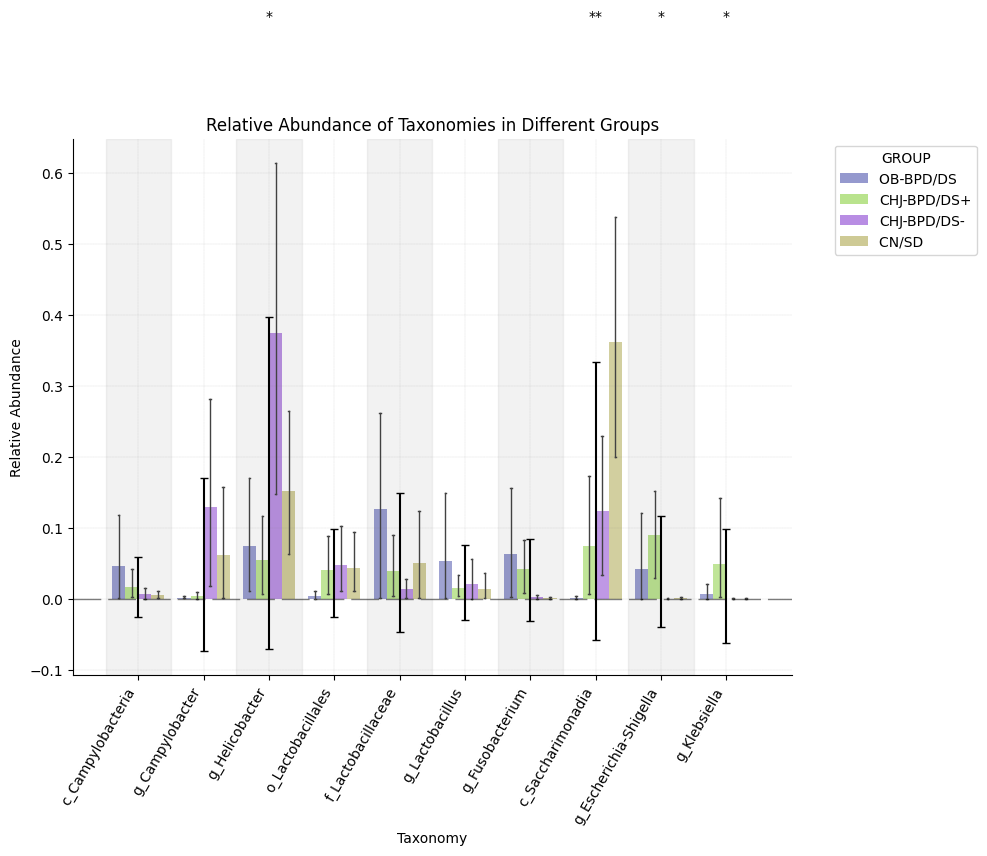


=== Analyzing Subgroup: MAMLI ===

=== SHANNON ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)   1.706534   3.0  0.592748  0.625795
Residual  23.032165  24.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.4089  0.8499 -1.8044  0.9866   False
1  CHJ-BPD/DS+       CN/SD    -0.6155  0.5871 -1.9472  0.7163   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.3921  0.8838 -1.8723  1.0881   False
3  CHJ-BPD/DS-       CN/SD    -0.2066  0.9810 -1.7101  1.2969   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0168  1.0000 -1.6196  1.6532   False


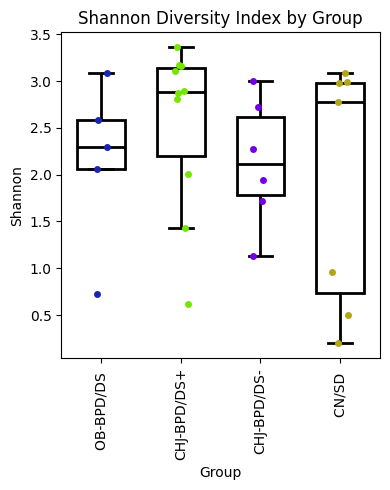


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.180468   3.0  0.730295  0.544023
Residual  1.976939  24.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1085  0.8833 -0.5173  0.3004   False
1  CHJ-BPD/DS+       CN/SD    -0.2072  0.4734 -0.5973  0.1830   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0731  0.9660 -0.5067  0.3606   False
3  CHJ-BPD/DS-       CN/SD    -0.0987  0.9253 -0.5392  0.3418   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0354  0.9969 -0.4440  0.5148   False


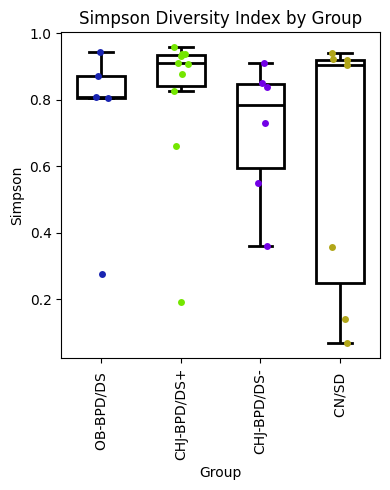


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)   38.873810   3.0  0.911372  0.450205
Residual  341.233333  24.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.9667  0.9591 -4.4048  6.3382   False
1  CHJ-BPD/DS+       CN/SD     0.8000  0.9727 -4.3261  5.9261   False
2  CHJ-BPD/DS+   OB-BPD/DS    -2.4000  0.6558 -8.0973  3.2973   False
3  CHJ-BPD/DS-       CN/SD    -0.1667  0.9998 -5.9537  5.6204   False
4  CHJ-BPD/DS-   OB-BPD/DS    -3.3667  0.4677 -9.6653  2.9320   False


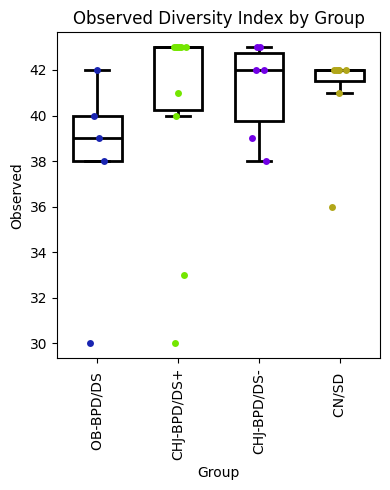


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.122718   3.0  0.615464  0.611673
Residual  1.595133  24.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1085  0.8467 -0.4758  0.2587   False
1  CHJ-BPD/DS+       CN/SD    -0.1668  0.5642 -0.5172  0.1837   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0960  0.9038 -0.4855  0.2936   False
3  CHJ-BPD/DS-       CN/SD    -0.0582  0.9769 -0.4539  0.3375   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0126  0.9998 -0.4181  0.4432   False


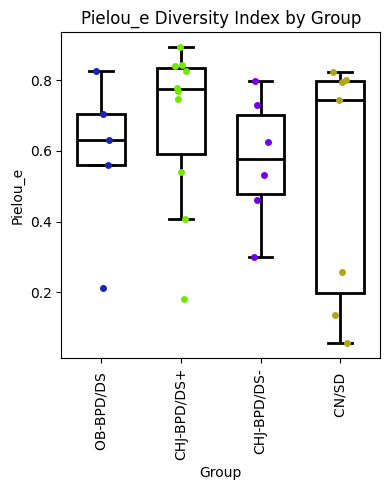

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:475: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


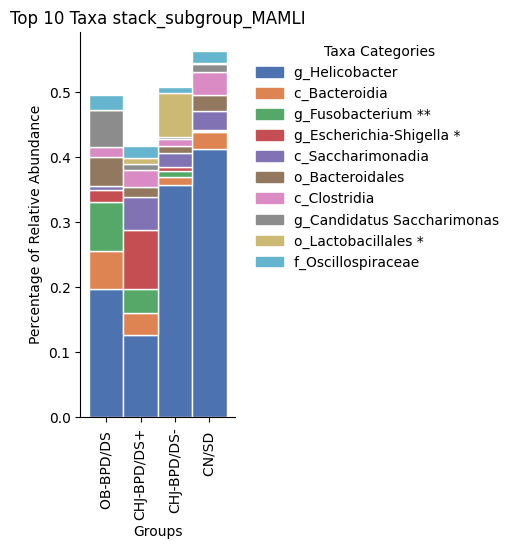

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:586: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


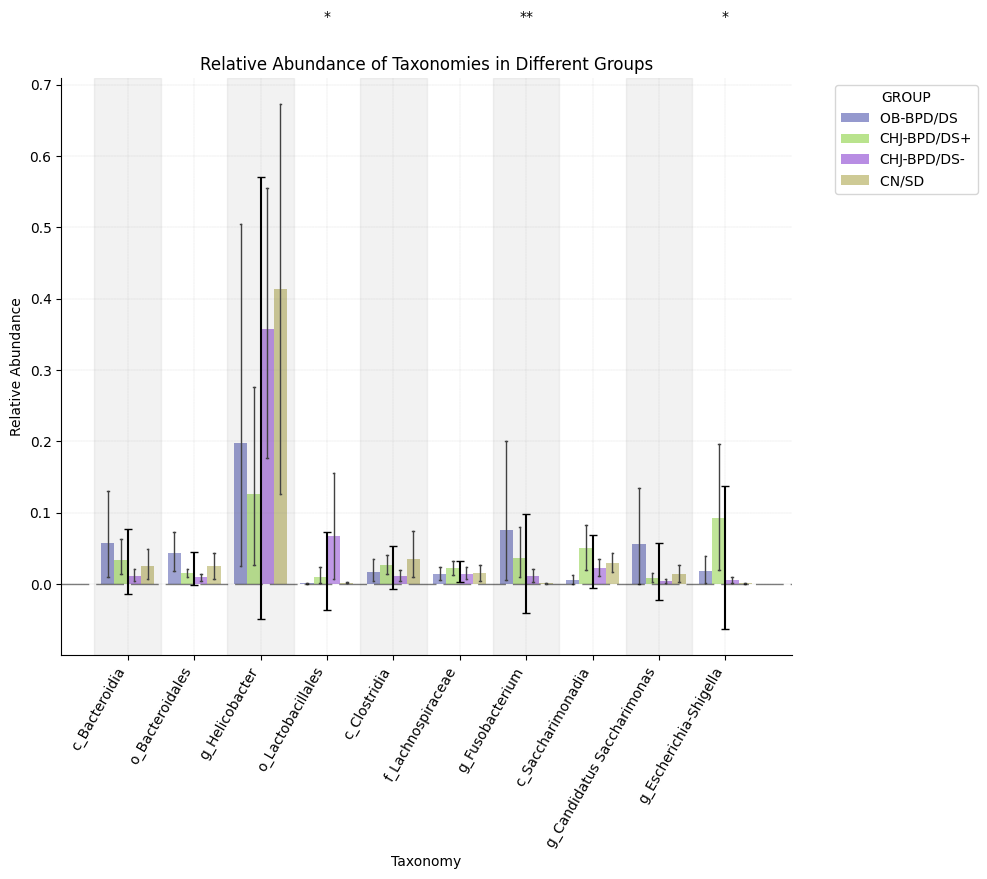


=== Analyzing Subgroup: MAM-D ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  1.591530   3.0  1.356336  0.280935
Residual  8.996096  23.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.6152  0.2697 -1.5274  0.2970   False
1  CHJ-BPD/DS+       CN/SD    -0.4447  0.5054 -1.3169  0.4275   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2094  0.9310 -1.1747  0.7560   False
3  CHJ-BPD/DS-       CN/SD     0.1705  0.9606 -0.7924  1.1333   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.4058  0.7098 -0.6421  1.4538   False


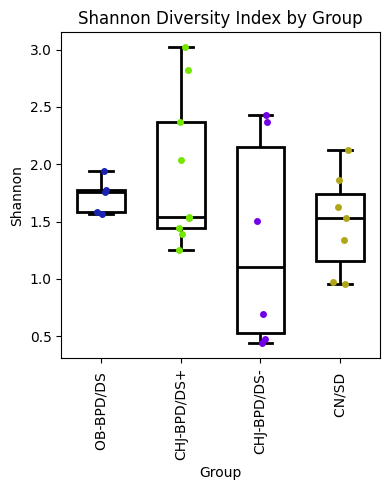


=== SIMPSON ANOVA ===
             sum_sq    df         F   PR(>F)
C(GROUP)  0.376317   3.0  2.887406  0.05745
Residual  0.999200  23.0       NaN      NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.2508  0.1314 -0.5548  0.0532   False
1  CHJ-BPD/DS+       CN/SD    -0.1990  0.2579 -0.4897  0.0917   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0276  0.9952 -0.2941  0.3493   False
3  CHJ-BPD/DS-       CN/SD     0.0518  0.9696 -0.2691  0.3727   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.2784  0.1516 -0.0709  0.6276   False


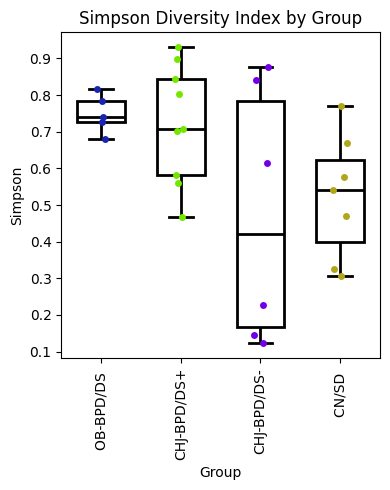


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)  540.296296   3.0  9.137364  0.000362
Residual  453.333333  23.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj    lower    upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -4.0000  0.3418 -10.4752   2.4752   False
1  CHJ-BPD/DS+       CN/SD     0.3333  0.9988  -5.8581   6.5248   False
2  CHJ-BPD/DS+   OB-BPD/DS   -11.6667  0.0005 -18.5193  -4.8140    True
3  CHJ-BPD/DS-       CN/SD     4.3333  0.3200  -2.5018  11.1685   False
4  CHJ-BPD/DS-   OB-BPD/DS    -7.6667  0.0418 -15.1061  -0.2273    True


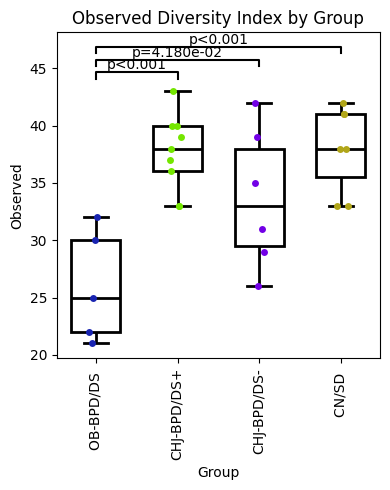


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.134263   3.0  1.482886  0.245463
Residual  0.694153  23.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1581  0.3334 -0.4115  0.0953   False
1  CHJ-BPD/DS+       CN/SD    -0.1228  0.5107 -0.3650  0.1195   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0002  1.0000 -0.2684  0.2679   False
3  CHJ-BPD/DS-       CN/SD     0.0353  0.9829 -0.2321  0.3028   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1579  0.4531 -0.1332  0.4490   False


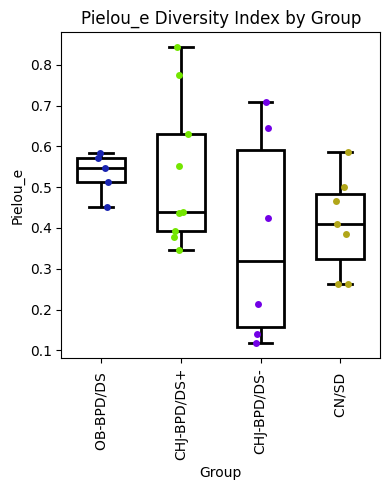

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:475: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


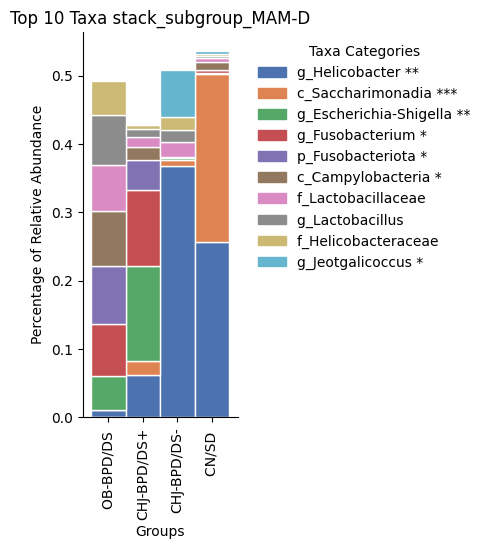

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:586: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


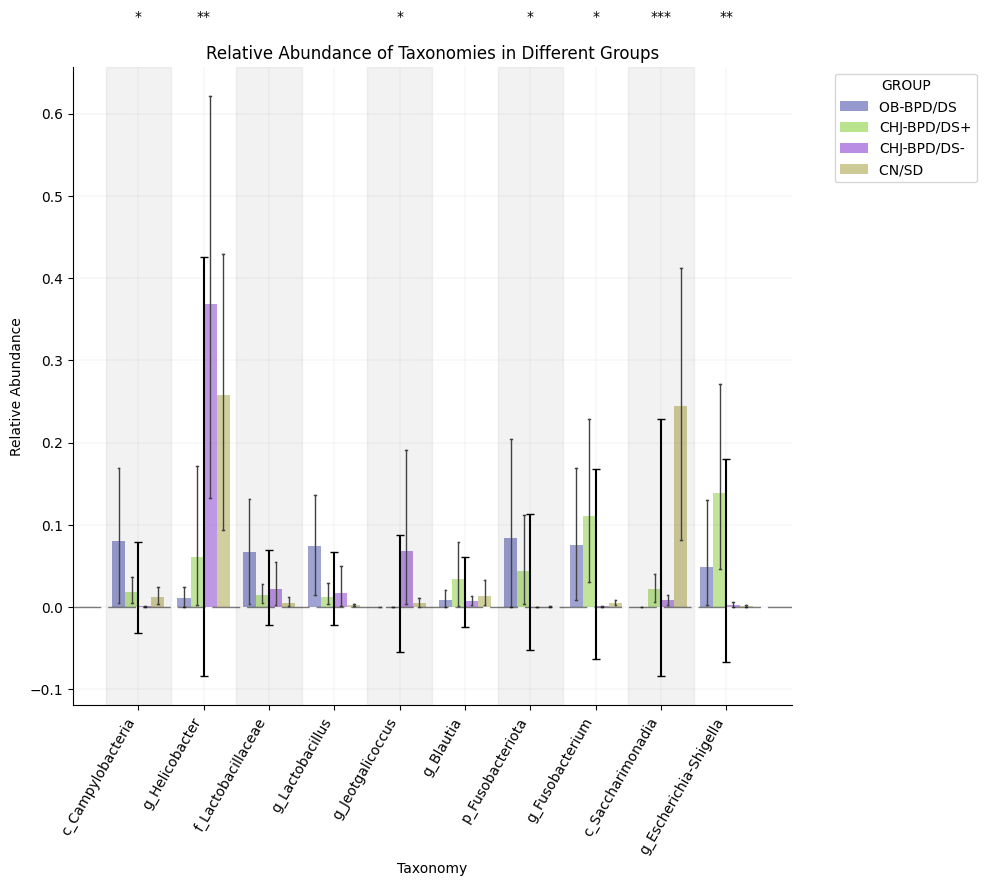


=== Analyzing Subgroup: Fecal ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.247409   3.0  0.402064  0.753239
Residual  3.692088  18.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0359  0.9988 -0.7272  0.6554   False
1  CHJ-BPD/DS+       CN/SD     0.0560  0.9970 -0.7278  0.8399   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2630  0.7797 -1.0468  0.5209   False
3  CHJ-BPD/DS-       CN/SD     0.0920  0.9888 -0.7343  0.9182   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.2270  0.8640 -1.0533  0.5992   False


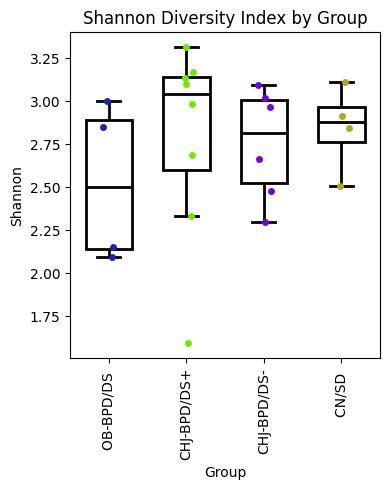


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.006822   3.0  0.367587  0.777264
Residual  0.111346  18.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0118  0.9923 -0.1318  0.1083   False
1  CHJ-BPD/DS+       CN/SD     0.0270  0.9426 -0.1092  0.1631   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0290  0.9301 -0.1651  0.1071   False
3  CHJ-BPD/DS-       CN/SD     0.0388  0.8698 -0.1047  0.1822   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0172  0.9862 -0.1607  0.1263   False


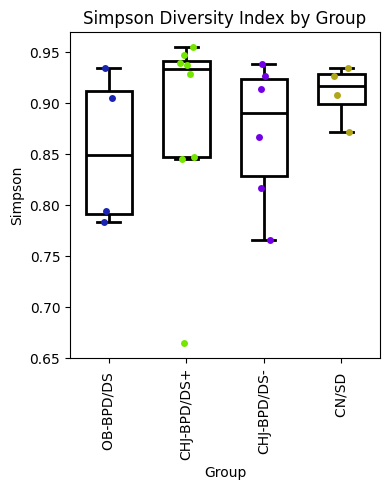


=== OBSERVED ANOVA ===
              sum_sq    df         F  PR(>F)
C(GROUP)  20.318182   3.0  3.694215  0.0312
Residual  33.000000  18.0       NaN     NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-      1.00  0.5344 -1.0667  3.0667   False
1  CHJ-BPD/DS+       CN/SD       0.75  0.8026 -1.5934  3.0934   False
2  CHJ-BPD/DS+   OB-BPD/DS      -1.75  0.1874 -4.0934  0.5934   False
3  CHJ-BPD/DS-       CN/SD      -0.25  0.9916 -2.7202  2.2202   False
4  CHJ-BPD/DS-   OB-BPD/DS      -2.75  0.0261 -5.2202 -0.2798    True


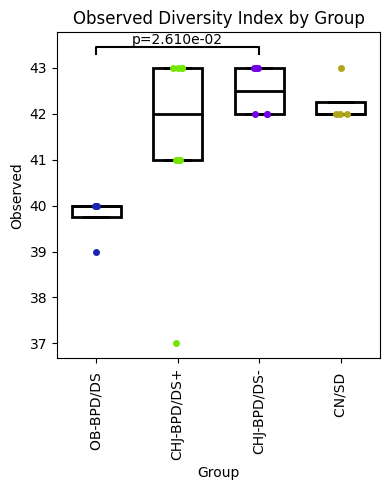


=== PIELOU_E ANOVA ===
             sum_sq    df        F    PR(>F)
C(GROUP)  0.013446   3.0  0.31715  0.812811
Residual  0.254375  18.0      NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0130  0.9970 -0.1944  0.1685   False
1  CHJ-BPD/DS+       CN/SD     0.0128  0.9980 -0.1930  0.2185   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0616  0.8319 -0.2673  0.1442   False
3  CHJ-BPD/DS-       CN/SD     0.0258  0.9865 -0.1911  0.2426   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0486  0.9198 -0.2655  0.1683   False


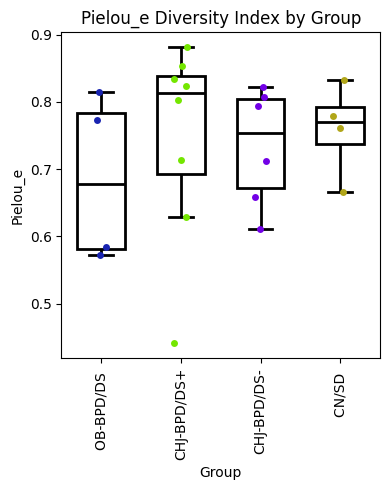

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:475: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


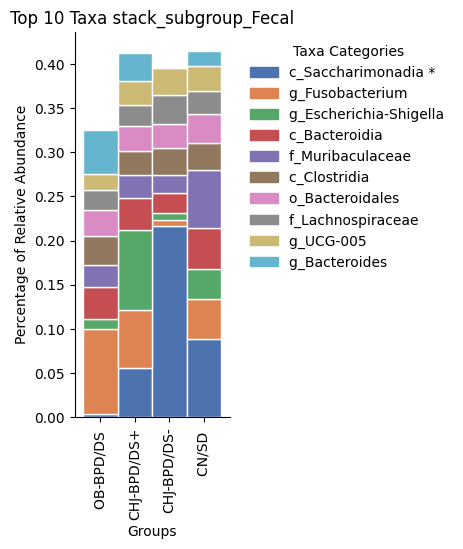

/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:586: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


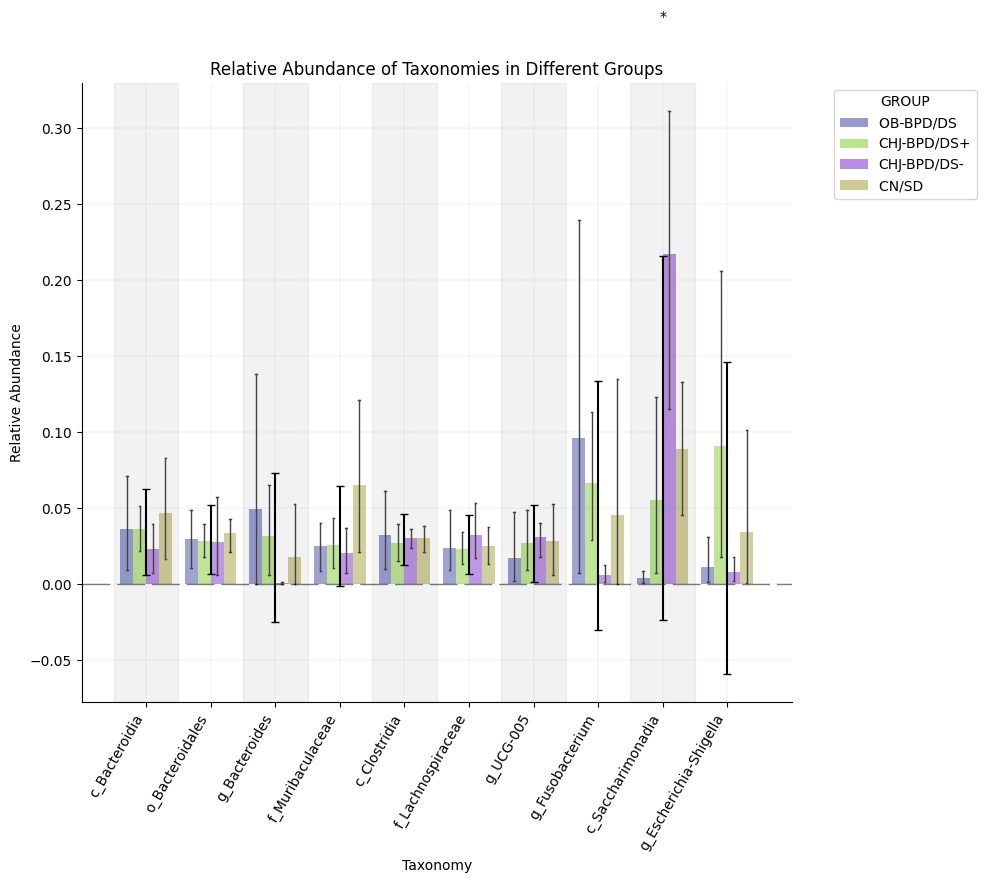

In [4]:
results_dict = msa.analyze_all_subgroups(df, SUPGROUP_LIST, group_list=GROUP_LIST)